In [1]:
%load_ext memory_profiler

In [2]:
import sys
sys.path.append("../")
import time
from typing import List 
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sdd_cxx.ext import SddCxxParameter
from sdd_cxx.ext import SddCxxSensitivity
from sdd_cxx.ext import SddCxxRectangleList
from sdd_cxx.ext import SddCxxRectangleLists
from sdd_cxx.ext import SddCxxLabelList
from sdd_cxx.ext import SddCxxAnomalyList
from sdd_cxx.ext import SddCxx

In [3]:
def to_components_img(
    scp: SddCxxParameter,
    components: np.ndarray
) -> np.ndarray:
    n_components, n_features = components.shape
    p_h = scp.param.drd.patch_size.height
    p_w = scp.param.drd.patch_size.width
    # FIXME: Consider better way instaed of (p_h, p_w * n_components).
    i_h = p_h
    i_w = p_w * n_components 
    img = np.zeros(shape = (i_h, i_w), dtype = np.uint8)
    r = i_h // p_h
    c = i_w // p_w
    offset = np.min(components)
    scale = (2 ** 8) / (np.max(components) - offset)
    for i in range(r):
        for j in range(c):
            k = i * c + j
            if k < n_components:
                d = scale * (components[k, :] - offset)
                # FIXME: Add gamma correction?
                d[d > 2 ** 8 - 1] = 2 ** 8 - 1
                d[d < 0] = 0
                img[(p_h * i):(p_h * (i + 1)), (p_w * j):(p_w * (j + 1))] = d.reshape((p_h, p_w)).astype(np.uint8)
    return img

def to_label_string(
    scs: SddCxxSensitivity,
    label: np.int8
) -> str:
    if label == scs.sen.label_ok:
        return "OK"
    if label == scs.sen.label_ng:
        return "NG"
    return "UNKNOWN"

def to_grayscale_heatmap(
    anomaly_img: np.ndarray
) -> np.ndarray:
    denom = anomaly_img.max()
    if denom == 0:
        hm = np.zeros_like(anomaly_img, dtype = np.uint8)
        return hm
    else:
        scale = 2**8 / denom
        hm = scale * anomaly_img
        hm[hm < 0] = 0
        hm[hm > 2**8 - 1] = 2**8 - 1
        return hm.astype(np.uint8)

def to_overlap_img(
    bg: np.ndarray,
    anomaly_img: np.ndarray
) -> np.ndarray:
    tmp = to_grayscale_heatmap(anomaly_img = anomaly_img)
    # FIXME: Use perceptually-uniform color map?
    # FIXME: Use cv::COLORMAP_TURBO instead of cv::COLORMAP_JET if possible?
    #        See also following blog post.
    #        * Anton Mikhailov, "Turbo, An Improved Rainbow Colormap for Visualization", 2019/08/20
    #          https://ai.googleblog.com/2019/08/turbo-improved-rainbow-colormap-for.html
    # FIXME: opencv-python==3.4.5.20 has missing declaration of cv2.COLORMAP_TURBO.
    hm = cv2.applyColorMap(tmp, cv2.COLORMAP_JET)
    mode = np.argmax(np.bincount(tmp.flatten()))
    hm[tmp <= mode] = 0
    overlap_img = cv2.addWeighted(bg, 1.0, hm, 0.7, 0)
    return overlap_img

def to_annotate_img(
    bg: np.ndarray,
    rs: SddCxxRectangleList
) -> np.ndarray:
    annotate_img = bg
    color = (0, 0, 255)
    thickness = 4
    for r in rs:
        top_left     = (r.rect.x, r.rect.y)
        bottom_right = (r.rect.x + r.rect.width - 1, r.rect.y + r.rect.height - 1)
        annotate_img = cv2.rectangle(annotate_img, top_left, bottom_right, color, thickness)
    return annotate_img
        
def show_summary(
    paths: List[str],
    imgs: List[np.ndarray],
    anomaly_imgs: List[np.ndarray],
    rects: SddCxxRectangleLists,
    labels: SddCxxLabelList,
    anomalys: SddCxxAnomalyList
) -> None:
    for (path, img, anomaly_img, rs, label, anomaly) in zip(paths, imgs, anomaly_imgs, rects, labels, anomalys):
        print(f"test image = {path}")
        print(f" interpreted label = {to_label_string(scs = scs, label = label)}")
        print(f" anomaly score = {anomaly}")
        print(f" detected rectangles = {{")
        for r in rs:
            print(f"  {{ rectangle = {{ x = {r.rect.x}, y = {r.rect.y}, width = {r.rect.width}, height = {r.rect.height} }}, ")
            print(f"    circle area = {r.area},")
            print(f"    anomaly score = {r.anomaly}")
            print(f"    interpreted label = {to_label_string(scs = scs, label = r.label)} }},")
        print(f" }}")
        # FIXME: Do not expect imgs are either of BGR or grayscale.
        if len(img.shape) == 3 and img.shape[-1] == 3:
            bg = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) >> 1, cv2.COLOR_GRAY2BGR)
        else:
            bg = cv2.cvtColor(img >> 1, cv2.COLOR_GRAY2BGR)
        overlap_img = to_overlap_img(bg = bg, anomaly_img = anomaly_img)
        annotate_img = to_annotate_img(bg = bg, rs = rs);
        plt.figure(figsize = (8, 8))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(overlap_img, cv2.COLOR_BGR2RGB))
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(annotate_img, cv2.COLOR_BGR2RGB))
        plt.show()
        plt.close()

peak memory: 132.80 MiB, increment: 0.88 MiB
SddCxxParameter.__init__: 0.177[s]
peak memory: 132.96 MiB, increment: 0.16 MiB
SddCxxParameter.save: 0.177[s]
peak memory: 134.04 MiB, increment: 1.08 MiB
SddCxx.__init__: 0.178[s]
peak memory: 184.94 MiB, increment: 40.98 MiB
SddCxx.fit: 0.740[s]
peak memory: 148.03 MiB, increment: 0.01 MiB
SddCxx.save: 0.189[s]
peak memory: 148.03 MiB, increment: 0.00 MiB
SddCxx.expose: 0.186[s]
peak memory: 148.36 MiB, increment: 0.00 MiB
SddCxx.expose: 0.184[s]
peak memory: 207.71 MiB, increment: 55.91 MiB
SddCxx.predict: 0.383[s]
peak memory: 175.27 MiB, increment: 0.00 MiB
SddCxx.free: 0.188[s]
peak memory: 175.28 MiB, increment: 0.00 MiB
SddCxxSensitivity.__init__: 0.194[s]
peak memory: 175.28 MiB, increment: 0.00 MiB
SddCxxSensitivity.save: 0.214[s]
peak memory: 176.65 MiB, increment: 1.38 MiB
SddCxx.interpret: 0.187[s]
test image = ../data/preprocessed_wood_block/test/OK/OK1-23-01.jpg
 interpreted label = OK
 anomaly score = 0.00048380452871640833


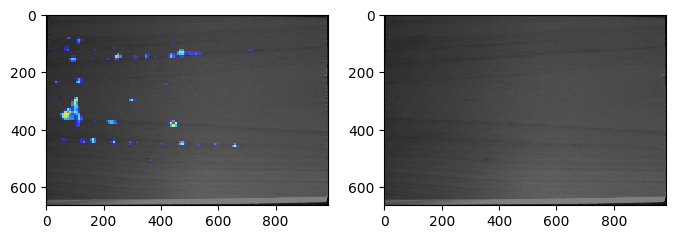

test image = ../data/preprocessed_wood_block/test/NG/NG1-23-02.jpg
 interpreted label = NG
 anomaly score = 0.04311373917550981
 detected rectangles = {
  { rectangle = { x = 712, y = 448, width = 48, height = 128 }, 
    circle area = 14402.674865553941,
    anomaly score = 0.008758157952430845
    interpreted label = NG },
  { rectangle = { x = 296, y = 392, width = 56, height = 112 }, 
    circle area = 12052.759149444346,
    anomaly score = 0.03969984408380406
    interpreted label = NG },
  { rectangle = { x = 128, y = 360, width = 72, height = 128 }, 
    circle area = 16626.925510396704,
    anomaly score = 0.01376665666493479
    interpreted label = NG },
  { rectangle = { x = 480, y = 184, width = 72, height = 96 }, 
    circle area = 11047.447090056152,
    anomaly score = 0.027800388966956496
    interpreted label = NG },
  { rectangle = { x = 776, y = 112, width = 48, height = 160 }, 
    circle area = 21590.647377941474,
    anomaly score = 0.004983752552057408
    interp

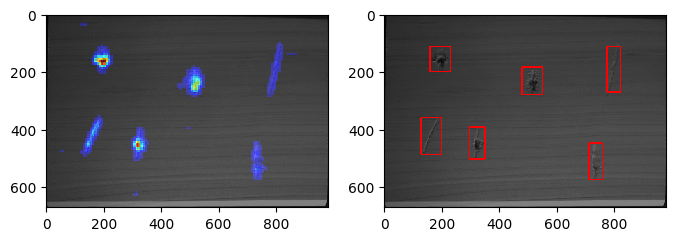

In [4]:
LPI    = False
TOP    = 32
BOTTOM = 32
LEFT   = 32
RIGHT  = 32

start = time.time()
%memit scp = SddCxxParameter()
end = time.time()
print(f"SddCxxParameter.__init__: {(end - start):.3f}[s]")

if LPI:
    start = time.time()
    %memit scp.load(path = "./howto_ext_image.drd.param.pb")
    end = time.time()
    print(f"SddCxxParameter.load: {(end - start):.3f}[s]")
else:
    scp.param.alg = "DictionaryReconstructDetector"
    scp.param.license.lic = "../license/node-locked.lic"
    scp.param.drd.patch_size.height      = 16
    scp.param.drd.patch_size.width       = 16
    scp.param.drd.extraction_step.height = 8
    scp.param.drd.extraction_step.width  = 8
    scp.param.drd.train_size             = -1
    scp.param.drd.b_acd                  = True

    start = time.time()
    %memit scp.save(path = "./howto_ext_image.drd.param.pb")
    end = time.time()
    print(f"SddCxxParameter.save: {(end - start):.3f}[s]")

start = time.time()
%memit sc = SddCxx(scp = scp)
end = time.time()
print(f"SddCxx.__init__: {(end - start):.3f}[s]")

if LPI:
    start = time.time()
    %memit sc.load(path = "./howto_ext_image.drd.ctx.pb")
    end = time.time()
    print(f"SddCxx.load: {(end - start):.3f}[s]")
else:
    paths = [
        "../data/preprocessed_wood_block/train/T1-23-01.jpg",
        "../data/preprocessed_wood_block/train/T1-23-02.jpg",
    ]
    imgs = []
    masks = []
    for path in paths:
        bgr  = cv2.imread(path)
        gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
        bw = np.zeros_like(gray, dtype = np.uint8)
        if TOP > 0:
            bw[0:TOP, :] = 255
        if BOTTOM > 0:
            bw[-BOTTOM:, :] = 255
        if LEFT > 0:
            bw[:, 0:LEFT] = 255
        if RIGHT > 0:
            bw[:, -RIGHT:] = 255
        imgs.append(gray)
        masks.append(bw)
    start = time.time()
    %memit sc.fit(imgs = imgs, masks = masks)
    end = time.time()
    print(f"SddCxx.fit: {(end - start):.3f}[s]")

    start = time.time()
    %memit sc.save(path = "./howto_ext_image.drd.ctx.pb")
    end = time.time()
    print(f"SddCxx.save: {(end - start):.3f}[s]")
    
    # NOTE: components should be pre-allocated.
    n_features = scp.param.drd.patch_size.height * scp.param.drd.patch_size.width
    components = np.empty(shape = (scp.param.drd.n_components, n_features), dtype = np.float64)
    start = time.time()
    %memit sc.expose(hint = "drd.components", exposed = components)
    end = time.time()
    print(f"SddCxx.expose: {(end - start):.3f}[s]")
    components_img = to_components_img(scp = scp, components = components)
    cv2.imwrite("./howto_ext_image.drd.components.png", components_img)
    
    # NOTE: contribution_l0 should be pre-allocated.
    contribution_l0 = np.empty(shape = (scp.param.drd.n_components, scp.param.drd.n_nonzero_coefs), dtype = np.float64)
    start = time.time()
    %memit sc.expose(hint = "drd.contribution.l0", exposed = contribution_l0)
    end = time.time()
    print(f"SddCxx.expose: {(end - start):.3f}[s]")
    np.savetxt("./howto_ext_image.drd.contribution.l0.txt", contribution_l0, fmt = "%.6e")
    
    #fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (8, 8))
    #ax1.imshow(components_img, cmap = 'gray', vmin = 0, vmax = 255)
    #ax1.set_xticks(ticks = np.linspace(0, scp.param.drd.patch_size.width * scp.param.drd.n_components, num = scp.param.drd.n_components + 1, dtype = np.intp), minor = False)
    #ax1.set_yticks(ticks = np.linspace(0, scp.param.drd.patch_size.height, num = 1 + 1, dtype = np.intp), minor = False)
    #ax1.set_title('drd.components')
    #for i in np.arange(0, contribution_l0.shape[1], 1, dtype = np.intp):
    #    ax2.plot(
    #        np.arange(0, contribution_l0.shape[0], 1, dtype = np.intp), contribution_l0[:, i],
    #        label = f"number of nonzero coefficients = {i + 1}", ls = '-', marker = '+'
    #    )
    #ax2.set_title('drd.contribution.l0')
    #ax2.set_xticks(ticks = np.linspace(0, scp.param.drd.n_components, num = scp.param.drd.n_components + 1, dtype = np.intp), minor = False)
    #ax2.set_yticks(ticks = np.linspace(0, contribution_l0.max(), num = 5 + 1, dtype = np.float64), minor = False)
    ##ax2.set_yscale('log', nonposy = 'mask') # FIXME: Log scale doesn't looks good compared one by gnuplot for non-positive y value.
    #ax2.set_xlabel('component index')
    #ax2.set_ylabel(r'$\ell_{0}$ contribution')
    #ax2.grid()
    #ax2.legend(bbox_to_anchor = (1, 1), loc = 'upper right', borderaxespad = 0)

paths = [
    "../data/preprocessed_wood_block/test/OK/OK1-23-01.jpg",
    "../data/preprocessed_wood_block/test/NG/NG1-23-02.jpg"
]
imgs = []
masks = []
anomaly_imgs = []
for path in paths:
    bgr  = cv2.imread(path)
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    bw   = np.zeros_like(gray, dtype = np.uint8)
    if TOP > 0:
        bw[0:TOP, :] = 255
    if BOTTOM > 0:
        bw[-BOTTOM:, :] = 255
    if LEFT > 0:
        bw[:, 0:LEFT] = 255
    if RIGHT > 0:
        bw[:, -RIGHT:] = 255
    anomaly_img = np.empty_like(gray, dtype = np.float64) # NOTE: anomaly_img should be pre-allocated.
    imgs.append(gray)
    masks.append(bw)
    anomaly_imgs.append(anomaly_img)
start = time.time()
%memit sc.predict(imgs = imgs, masks = masks, anomaly_imgs = anomaly_imgs)
end = time.time()
print(f"SddCxx.predict: {(end - start):.3f}[s]")

start = time.time()
%memit sc.free()
end = time.time()
print(f"SddCxx.free: {(end - start):.3f}[s]")

start = time.time()
%memit scs = SddCxxSensitivity()
end = time.time()
print(f"SddCxxSensitivity.__init__: {(end - start):.3f}[s]")

if LPI:
    start = time.time()
    %memit scs.load(path = "./howto_ext_image.drd.sen.pb")
    end = time.time()
    print(f"SddCxxSensitivity.load: {(end - start):.3f}[s]")
else:
    scs.sen.anomaly = 0.001
    scs.sen.area    = 8 * 8

    start = time.time()
    %memit scs.save(path = "./howto_ext_image.drd.sen.pb")
    end = time.time()
    print(f"SddCxxSensitivity.save: {(end - start):.3f}[s]")

rects    = SddCxxRectangleLists()
labels   = SddCxxLabelList()
anomalys = SddCxxAnomalyList()
start = time.time()
%memit sc.interpret(scs = scs, anomaly_imgs = anomaly_imgs, rects = rects, labels = labels, anomalys = anomalys)
end = time.time()
print(f"SddCxx.interpret: {(end - start):.3f}[s]")

show_summary(paths = paths, imgs = imgs, anomaly_imgs = anomaly_imgs, rects = rects, labels = labels, anomalys = anomalys)

peak memory: 190.65 MiB, increment: 0.04 MiB
SddCxxParameter.__init__: 0.188[s]
peak memory: 190.65 MiB, increment: 0.00 MiB
SddCxxParameter.save: 0.200[s]
peak memory: 190.66 MiB, increment: 0.00 MiB
SddCxx.__init__: 0.187[s]
peak memory: 241.33 MiB, increment: 50.32 MiB
SddCxx.fit: 0.942[s]
peak memory: 184.19 MiB, increment: 0.00 MiB
SddCxx.save: 0.220[s]
peak memory: 241.96 MiB, increment: 62.75 MiB
SddCxx.predict: 0.946[s]
peak memory: 215.85 MiB, increment: 0.00 MiB
SddCxx.free: 0.206[s]
peak memory: 215.86 MiB, increment: 0.00 MiB
SddCxxSensitivity.__init__: 0.200[s]
peak memory: 215.86 MiB, increment: 0.00 MiB
SddCxxSensitivity.save: 0.204[s]
peak memory: 216.43 MiB, increment: 0.57 MiB
SddCxx.interpret: 0.188[s]
test image = ../data/raspberry_pi/test/OK/ok_1_test.png
 interpreted label = OK
 anomaly score = 0.00497648083254128
 detected rectangles = {
 }


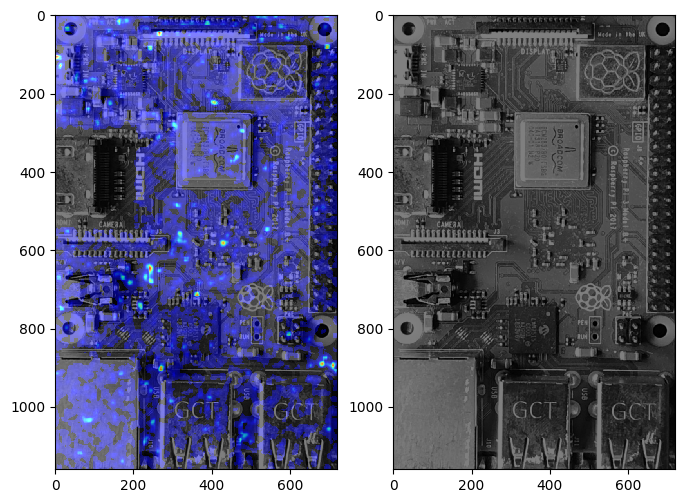

test image = ../data/raspberry_pi/test/NG/ng_0.png
 interpreted label = NG
 anomaly score = 1.5896099373006514
 detected rectangles = {
  { rectangle = { x = 524, y = 573, width = 84, height = 81 }, 
    circle area = 10437.191850397605,
    anomaly score = 1.5896099373006514
    interpreted label = NG },
  { rectangle = { x = 340, y = 475, width = 51, height = 31 }, 
    circle area = 2670.37208662859,
    anomaly score = 0.16833437831903653
    interpreted label = NG },
  { rectangle = { x = 273, y = 374, width = 31, height = 27 }, 
    circle area = 1237.7999573295951,
    anomaly score = 0.1477125559882201
    interpreted label = NG },
 }


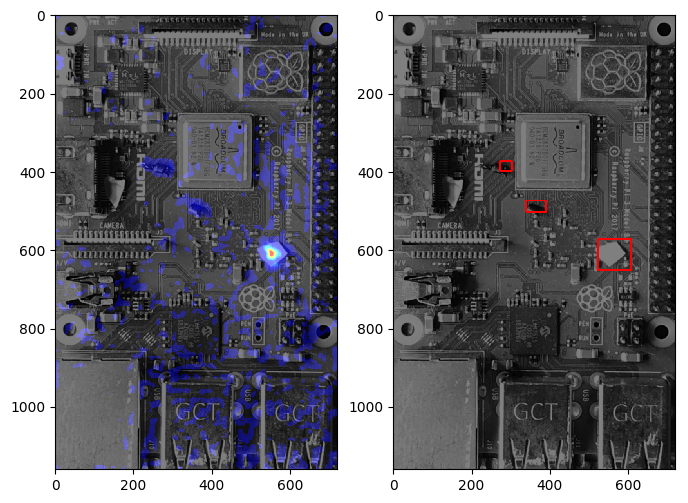

In [5]:
LPI = False
# NOTE: Following rectangular mask will exclude HDMI connector and surrounding area
MASK_START_R = 300
MASK_END_R = 540
MASK_START_C = 0
MASK_END_C = 200

start = time.time()
%memit scp = SddCxxParameter()
end = time.time()
print(f"SddCxxParameter.__init__: {(end - start):.3f}[s]")

if LPI:
    start = time.time()
    %memit scp.load(path = "./howto_ext_image.lpd.param.pb")
    end = time.time()
    print(f"SddCxxParameter.load: {(end - start):.3f}[s]")
else:
    scp.param.alg = "LocalPatternDetector"
    scp.param.license.lic = "../license/node-locked.lic"
    scp.param.lpd.patch_size.height      = 16
    scp.param.lpd.patch_size.width       = 16
    scp.param.lpd.extraction_step.height = 4
    scp.param.lpd.extraction_step.width  = 4

    start = time.time()
    %memit scp.save(path = "./howto_ext_image.lpd.param.pb")
    end = time.time()
    print(f"SddCxxParameter.save: {(end - start):.3f}[s]")

start = time.time()
%memit sc = SddCxx(scp = scp)
end = time.time()
print(f"SddCxx.__init__: {(end - start):.3f}[s]")

if LPI:
    start = time.time()
    %memit sc.load(path = "./howto_ext_image.lpd.ctx.pb")
    end = time.time()
    print(f"SddCxx.load: {(end - start):.3f}[s]")
else:
    paths = [
        "../data/raspberry_pi/train/ok_0_train.png",
        "../data/raspberry_pi/train/ok_9_train.png"
    ]
    imgs = []
    masks = []
    for path in paths:
        bgr  = cv2.imread(path)
        gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
        bw = np.zeros_like(gray, dtype = np.uint8)
        bw[MASK_START_R:MASK_END_R, MASK_START_C:MASK_END_C] = 255
        imgs.append(gray)
        masks.append(bw)
    start = time.time()
    %memit sc.fit(imgs = imgs, masks = masks)
    end = time.time()
    print(f"SddCxx.fit: {(end - start):.3f}[s]")

    start = time.time()
    %memit sc.save(path = "./howto_ext_image.lpd.ctx.pb")
    end = time.time()
    print(f"SddCxx.save: {(end - start):.3f}[s]")

paths = [
    "../data/raspberry_pi/test/OK/ok_1_test.png",
    "../data/raspberry_pi/test/NG/ng_0.png"
]
imgs = []
masks = []
anomaly_imgs = []
for path in paths:
    bgr  = cv2.imread(path)
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    bw = np.zeros_like(gray, dtype = np.uint8)
    bw[MASK_START_R:MASK_END_R, MASK_START_C:MASK_END_C] = 255
    anomaly_img = np.empty_like(gray, dtype = np.float64) # NOTE: anomaly_img should be pre-allocated.
    imgs.append(gray)
    masks.append(bw)
    anomaly_imgs.append(anomaly_img) 
start = time.time()
%memit sc.predict(imgs = imgs, masks = masks, anomaly_imgs = anomaly_imgs)
end = time.time()
print(f"SddCxx.predict: {(end - start):.3f}[s]")

start = time.time()
%memit sc.free()
end = time.time()
print(f"SddCxx.free: {(end - start):.3f}[s]")

start = time.time()
%memit scs = SddCxxSensitivity()
end = time.time()
print(f"SddCxxSensitivity.__init__: {(end - start):.3f}[s]")

if LPI:
    start = time.time()
    %memit scs.load(path = "./howto_ext_image.lpd.sen.pb")
    end = time.time()
    print(f"SddCxxSensitivity.load: {(end - start):.3f}[s]")
else:
    scs.sen.anomaly = 0.04
    scs.sen.area    = 400

    start = time.time()
    %memit scs.save(path = "./howto_ext_image.lpd.sen.pb")
    end = time.time()
    print(f"SddCxxSensitivity.save: {(end - start):.3f}[s]")

rects    = SddCxxRectangleLists()
labels   = SddCxxLabelList()
anomalys = SddCxxAnomalyList()
start = time.time()
%memit sc.interpret(scs = scs, anomaly_imgs = anomaly_imgs, rects = rects, labels = labels, anomalys = anomalys)
end = time.time()
print(f"SddCxx.interpret: {(end - start):.3f}[s]")

show_summary(paths = paths, imgs = imgs, anomaly_imgs = anomaly_imgs, rects = rects, labels = labels, anomalys = anomalys)

peak memory: 216.66 MiB, increment: 0.01 MiB
SddCxxParameter.__init__: 0.195[s]
peak memory: 216.66 MiB, increment: 0.00 MiB
SddCxxParameter.save: 0.178[s]
peak memory: 673.98 MiB, increment: 457.32 MiB
SddCxx.__init__: 16.303[s]
peak memory: 1188.71 MiB, increment: 514.73 MiB
SddCxx.fit: 3.861[s]
peak memory: 1044.57 MiB, increment: 0.00 MiB
SddCxx.save: 0.590[s]
peak memory: 1044.57 MiB, increment: 0.00 MiB
SddCxx.predict: 0.889[s]
peak memory: 553.31 MiB, increment: -404.73 MiB
SddCxx.free: 0.240[s]
peak memory: 553.31 MiB, increment: 0.00 MiB
SddCxxSensitivity.__init__: 0.209[s]
peak memory: 553.31 MiB, increment: 0.00 MiB
SddCxxSensitivity.save: 0.229[s]
peak memory: 553.31 MiB, increment: 0.00 MiB
SddCxx.interpret: 0.195[s]
test image = ../data/raspberry_pi/test/OK/ok_1_test.png
 interpreted label = OK
 anomaly score = 0.16775977611541748
 detected rectangles = {
 }


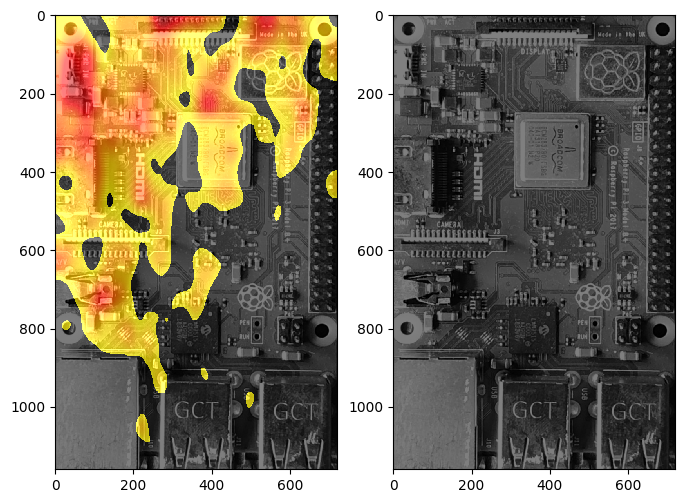

test image = ../data/raspberry_pi/test/NG/ng_0.png
 interpreted label = NG
 anomaly score = 0.4780820608139038
 detected rectangles = {
  { rectangle = { x = 509, y = 547, width = 106, height = 150 }, 
    circle area = 26095.694567516966,
    anomaly score = 0.4780820608139038
    interpreted label = NG },
  { rectangle = { x = 347, y = 499, width = 50, height = 39 }, 
    circle area = 3019.8752864853027,
    anomaly score = 0.3153797388076782
    interpreted label = NG },
  { rectangle = { x = 114, y = 355, width = 191, height = 177 }, 
    circle area = 52681.45783069107,
    anomaly score = 0.4780799150466919
    interpreted label = NG },
 }


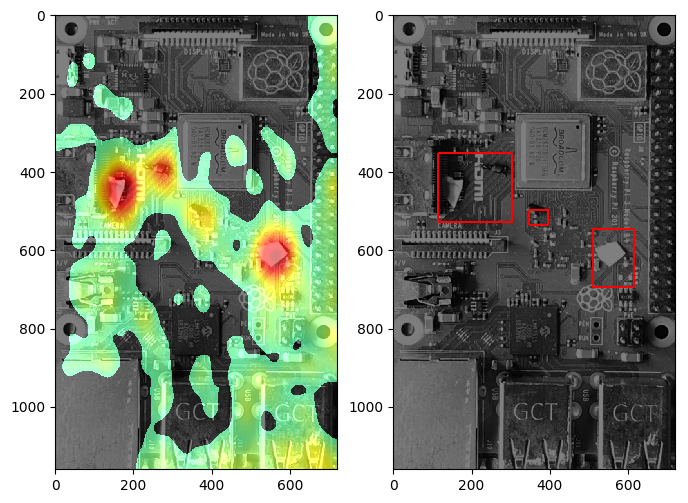

In [6]:
LPI = False

start = time.time()
%memit scp = SddCxxParameter()
end = time.time()
print(f"SddCxxParameter.__init__: {(end - start):.3f}[s]")

if LPI:
    start = time.time()
    %memit scp.load(path = "./howto_ext_image.psd.param.pb")
    end = time.time()
    print(f"SddCxxParameter.load: {(end - start):.3f}[s]")
else:
    scp.param.alg = "PatchSampleDetector"
    scp.param.license.lic = "../license/node-locked.lic"
    #scp.param.psd.onnx  = "../distfiles/resnet18.onnx";
    #scp.param.psd.names = [ "140", "156", "172" ];
    scp.param.psd.onnx  = "../distfiles/wide_resnet50_2.onnx";
    scp.param.psd.names = [ "356", "398", "460" ];
    scp.param.psd.b_soe = True;
    scp.param.psd.b_aer = False;

    start = time.time()
    %memit scp.save(path = "./howto_ext_image.psd.param.pb")
    end = time.time()
    print(f"SddCxxParameter.save: {(end - start):.3f}[s]")

start = time.time()
%memit sc = SddCxx(scp = scp)
end = time.time()
print(f"SddCxx.__init__: {(end - start):.3f}[s]")

if LPI:
    start = time.time()
    %memit sc.load(path = "./howto_ext_image.psd.ctx.pb")
    end = time.time()
    print(f"SddCxx.load: {(end - start):.3f}[s]")
else:
    paths = [
        "../data/raspberry_pi/train/ok_0_train.png",
        "../data/raspberry_pi/train/ok_1_train.png",
        "../data/raspberry_pi/train/ok_2_train.png",
        "../data/raspberry_pi/train/ok_3_train.png",
        "../data/raspberry_pi/train/ok_4_train.png",
        "../data/raspberry_pi/train/ok_5_train.png",
        "../data/raspberry_pi/train/ok_6_train.png",
        "../data/raspberry_pi/train/ok_7_train.png",
        "../data/raspberry_pi/train/ok_8_train.png",
        "../data/raspberry_pi/train/ok_9_train.png"
    ]
    color_imgs = []
    for path in paths:
        bgr = cv2.imread(path)
        color_imgs.append(bgr)
    start = time.time()
    %memit sc.fit(color_imgs = color_imgs)
    end = time.time()
    print(f"SddCxx.fit: {(end - start):.3f}[s]")

    start = time.time()
    %memit sc.save(path = "./howto_ext_image.psd.ctx.pb")
    end = time.time()
    print(f"SddCxx.save: {(end - start):.3f}[s]")

paths = [
    "../data/raspberry_pi/test/OK/ok_1_test.png",
    "../data/raspberry_pi/test/NG/ng_0.png"
]
color_imgs = []
anomaly_imgs = []
for path in paths:
    bgr = cv2.imread(path)
    anomaly_img = np.empty(shape = bgr.shape[:2], dtype = np.float64) # NOTE: anomaly_img should be pre-allocated.
    color_imgs.append(bgr)
    anomaly_imgs.append(anomaly_img)
start = time.time()
%memit sc.predict(color_imgs = color_imgs, anomaly_imgs = anomaly_imgs)
end = time.time()
print(f"SddCxx.predict: {(end - start):.3f}[s]")

start = time.time()
%memit sc.free()
end = time.time()
print(f"SddCxx.free: {(end - start):.3f}[s]")

start = time.time()
%memit scs = SddCxxSensitivity()
end = time.time()
print(f"SddCxxSensitivity.__init__: {(end - start):.3f}[s]")

if LPI:
    start = time.time()
    %memit scs.load(path = "./howto_ext_image.lpd.sen.pb")
    end = time.time()
    print(f"SddCxxSensitivity.load: {(end - start):.3f}[s]")
else:
    #scs.sen.anomaly = 0.600
    scs.sen.anomaly = 0.308
    scs.sen.area    = 400

    start = time.time()
    %memit scs.save(path = "./howto_ext_image.lpd.sen.pb")
    end = time.time()
    print(f"SddCxxSensitivity.save: {(end - start):.3f}[s]")

rects    = SddCxxRectangleLists()
labels   = SddCxxLabelList()
anomalys = SddCxxAnomalyList()
start = time.time()
%memit sc.interpret(scs = scs, anomaly_imgs = anomaly_imgs, rects = rects, labels = labels, anomalys = anomalys)
end = time.time()
print(f"SddCxx.interpret: {(end - start):.3f}[s]")

show_summary(paths = paths, imgs = color_imgs, anomaly_imgs = anomaly_imgs, rects = rects, labels = labels, anomalys = anomalys)

In [7]:
help(scp)

Help on SddCxxParameter in module sdd_cxx.ext_impl object:

class SddCxxParameter(pybind11_builtins.pybind11_object)
 |  Opaque C++ `class` for parameter setting.
 |  
 |  Method resolution order:
 |      SddCxxParameter
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(self: sdd_cxx.ext_impl.SddCxxParameter) -> None
 |      
 |      Opaque C++ constructor.
 |      
 |      Set default parameter.
 |      For default value, see descriptions for lower members.
 |  
 |  load(...)
 |      load(self: sdd_cxx.ext_impl.SddCxxParameter, path: str) -> None
 |      
 |      Opaque C++ member function.
 |      
 |      Load parameter setting from file.
 |      Optionally, call this function before overwrite.
 |      To maximize file compatibility,
 |      non-specified algorithm specific parameter setting won't be loaded.
 |      
 |      Parameters
 |      ----------
 |      path: str
 |          Opaque C++ `s

In [8]:
help(scp.param)

Help on sdd_cxx_parameter_t in module sdd_cxx.ext_impl object:

class sdd_cxx_parameter_t(pybind11_builtins.pybind11_object)
 |  Opaque C++ `struct` for parameter setting.
 |  
 |  Method resolution order:
 |      sdd_cxx_parameter_t
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  alg
 |      Opaque C++ `std::string`.
 |      `alg` is a string that specifies algorithm.
 |      Currently, one of following should be specified;
 |      * `"DictionaryReconstructDetector"`
 |      * `"LocalPatternDetector"`
 |      * `"PatchSampleDetector"`
 |      * `"DictionaryReconstruct"`
 |      Default is `""`; empty string, thus you should overwrite explicitly.
 |  
 |  dr
 |      Opaque C++ `struct` for DR.
 |      D

In [9]:
help(scp.param.license)

Help on sdd_cxx_parameter_t_license_s in module sdd_cxx.ext_impl object:

class sdd_cxx_parameter_t_license_s(pybind11_builtins.pybind11_object)
 |  Opaque C++ `struct` for license.
 |  
 |  Method resolution order:
 |      sdd_cxx_parameter_t_license_s
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  lic
 |      Opaque C++ `std::string`.
 |      `lic` is a string that specifies path to license file.
 |      Currently, only node-locked license is supported.
 |      Default is `"/etc/sdd_cxx.lic"`.
 |  
 |  ----------------------------------------------------------------------
 |  Static methods inherited from pybind11_builtins.pybind11_object:
 |  
 |  __new__(*args, **kwargs) from pybind11_builtins.pybi

In [10]:
help(scp.param.drd)

Help on sdd_cxx_parameter_t_drd_s in module sdd_cxx.ext_impl object:

class sdd_cxx_parameter_t_drd_s(pybind11_builtins.pybind11_object)
 |  Opaque C++ `struct` for DRD.
 |  
 |  Method resolution order:
 |      sdd_cxx_parameter_t_drd_s
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  b_acd
 |      Opaque C++ `bool`.
 |      `b_acd` is used to enable internal "automatic component deactivation".
 |      Default is `False`.
 |      Set `True` to deactivate unused components on fit when predict,
 |      otherwise set `False` to have no extra calculation cost.
 |      If `b_acd` is `True`, "drd.contribution.l0" is calculated even `b_csc` is `False`.
 |      Because each component deactivation is determined 

In [11]:
help(scp.param.lpd)

Help on sdd_cxx_parameter_t_lpd_s in module sdd_cxx.ext_impl object:

class sdd_cxx_parameter_t_lpd_s(pybind11_builtins.pybind11_object)
 |  Opaque C++ `struct` for LPD.
 |  
 |  Method resolution order:
 |      sdd_cxx_parameter_t_lpd_s
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  b_fha
 |      Opaque C++ `bool`.
 |      `b_fha` is used to enable "force high anomaly" for unfitted portions.
 |      Default is `True`; pixel level anomaly scores are tied to `1.0` where pixels are masked on fit but unmasked on predict.
 |      Although this behavior helps to detect incompleteness of masks on predict,
 |      masks on predict needs to be created by considering where masks on fit actually masked.
 |      

In [12]:
help(scs)

Help on SddCxxSensitivity in module sdd_cxx.ext_impl object:

class SddCxxSensitivity(pybind11_builtins.pybind11_object)
 |  Opaque C++ `class` for sensitivity setting.
 |  
 |  Method resolution order:
 |      SddCxxSensitivity
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(self: sdd_cxx.ext_impl.SddCxxSensitivity) -> None
 |      
 |      Opaque C++ constructor.
 |      
 |      Set default sensitivity.
 |      For default value, see descriptions for lower members.
 |  
 |  load(...)
 |      load(self: sdd_cxx.ext_impl.SddCxxSensitivity, path: str) -> None
 |      
 |      Opaque C++ member function.
 |      
 |      Load sensitivity setting from file.
 |      Optionally, call this function before overwrite.
 |      
 |      Parameters
 |      ----------
 |      path: str
 |          Opaque C++ `std::string` for path to file.
 |          This should end one of following file extensions;
 |      

In [13]:
help(scs.sen)

Help on sdd_cxx_sensitivity_t in module sdd_cxx.ext_impl object:

class sdd_cxx_sensitivity_t(pybind11_builtins.pybind11_object)
 |  Opaque C++ `struct` for sensitivity setting.
 |  
 |  Method resolution order:
 |      sdd_cxx_sensitivity_t
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  anomaly
 |      Opaque C++ `double`.
 |      `anomaly` is a threshold for binay mask.
 |      An anomaly image holds pixel level anomaly scores for paired test image.
 |      By greater-than-thresholding of anomaly image produces pixel level binary mask.
 |      Default is `0.0`; most sensitive.
 |      Note, `anomaly` should be in [`0.0`, `1.0`].
 |      Larger `anomaly` results to less sensitivity.
 |  
 |  area
 |  

In [14]:
help(rects)

Help on SddCxxRectangleLists in module sdd_cxx.ext_impl object:

class SddCxxRectangleLists(pybind11_builtins.pybind11_object)
 |  Opaque C++ `class` for list of list of detected rectangle.
 |  
 |  Method resolution order:
 |      SddCxxRectangleLists
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __bool__(...)
 |      __bool__(self: sdd_cxx.ext_impl.SddCxxRectangleLists) -> bool
 |      
 |      Check whether the list is nonempty
 |  
 |  __delitem__(...)
 |      __delitem__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __delitem__(self: sdd_cxx.ext_impl.SddCxxRectangleLists, arg0: int) -> None
 |      
 |      Delete the list elements at index ``i``
 |      
 |      2. __delitem__(self: sdd_cxx.ext_impl.SddCxxRectangleLists, arg0: slice) -> None
 |      
 |      Delete list elements using a slice object
 |  
 |  __getitem__(...)
 |      __getitem__(*args, **kwargs)
 |      Overloaded function.
 |      
 |

In [15]:
help(rects[-1][0])

Help on SddCxxRectangle in module sdd_cxx.ext_impl object:

class SddCxxRectangle(pybind11_builtins.pybind11_object)
 |  Opaque C++ `struct` for detected rectangle.
 |  
 |  Method resolution order:
 |      SddCxxRectangle
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  anomaly
 |      Opaque C++ `double`.
 |      `anomaly` is rectangle level anomaly score.
 |      `anomaly` is calculated by `method` of sensitivity setting.
 |  
 |  area
 |      Opaque C++ `double`.
 |      `area` is minimum enclosing circle area for this rectangle.
 |      Note, this is **not** `rect.width` times `rect.height`.
 |  
 |  label
 |      Opaque C++ `std::int8_t`.
 |      `label` is rectangle level label.
 |      `label` is

In [16]:
help(labels)

Help on SddCxxLabelList in module sdd_cxx.ext_impl object:

class SddCxxLabelList(pybind11_builtins.pybind11_object)
 |  Opaque C++ `class` for list of label.
 |  
 |  Method resolution order:
 |      SddCxxLabelList
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __bool__(...)
 |      __bool__(self: sdd_cxx.ext_impl.SddCxxLabelList) -> bool
 |      
 |      Check whether the list is nonempty
 |  
 |  __contains__(...)
 |      __contains__(self: sdd_cxx.ext_impl.SddCxxLabelList, x: int) -> bool
 |      
 |      Return true the container contains ``x``
 |  
 |  __delitem__(...)
 |      __delitem__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __delitem__(self: sdd_cxx.ext_impl.SddCxxLabelList, arg0: int) -> None
 |      
 |      Delete the list elements at index ``i``
 |      
 |      2. __delitem__(self: sdd_cxx.ext_impl.SddCxxLabelList, arg0: slice) -> None
 |      
 |      Delete list elements using a slice

In [17]:
help(anomalys)

Help on SddCxxAnomalyList in module sdd_cxx.ext_impl object:

class SddCxxAnomalyList(pybind11_builtins.pybind11_object)
 |  Opaque C++ `class` for list of anomaly score.
 |  
 |  Method resolution order:
 |      SddCxxAnomalyList
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __bool__(...)
 |      __bool__(self: sdd_cxx.ext_impl.SddCxxAnomalyList) -> bool
 |      
 |      Check whether the list is nonempty
 |  
 |  __contains__(...)
 |      __contains__(self: sdd_cxx.ext_impl.SddCxxAnomalyList, x: float) -> bool
 |      
 |      Return true the container contains ``x``
 |  
 |  __delitem__(...)
 |      __delitem__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __delitem__(self: sdd_cxx.ext_impl.SddCxxAnomalyList, arg0: int) -> None
 |      
 |      Delete the list elements at index ``i``
 |      
 |      2. __delitem__(self: sdd_cxx.ext_impl.SddCxxAnomalyList, arg0: slice) -> None
 |      
 |      Delete lis

In [18]:
help(sc)

Help on SddCxx in module sdd_cxx.ext_impl object:

class SddCxx(pybind11_builtins.pybind11_object)
 |  Opaque C++ `class` for sdd-cxx C++ extension.
 |  
 |  Method resolution order:
 |      SddCxx
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(self: sdd_cxx.ext_impl.SddCxx, scp: sdd_cxx.ext_impl.SddCxxParameter) -> None
 |      
 |      Opaque C++ constructor.
 |      
 |      Allocate context with parameter setting.
 |      
 |      Parameters
 |      ----------
 |      scp: SddCxxParameter
 |          Opaque C++ `class` for parameter setting.
 |  
 |  expose(...)
 |      expose(self: sdd_cxx.ext_impl.SddCxx, hint: str, exposed: numpy.ndarray[numpy.float64[m, n], flags.writeable, flags.c_contiguous]) -> None
 |      
 |      Opequed C++ member function.
 |      
 |      Expose context data internal by hint.
 |      
 |      Parameters
 |      ----------
 |      hint: str
 |          Opaque C++ `